In [1]:
# Make plots of the deviation in treatment vs mortality, stratified for different subcohorts of patients
# those with high SOFA: extract points where SOFA > 15
# those with low SOFA: extract points where SOFA < 5
# those with middling SOFA: between 5 and 15
# Plot variation over time?

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
try:
    import cPickle as pickle
except ImportError:
    import _pickle as pickle
import matplotlib.pyplot as plt

In [3]:
#Keep as 'Final2'
df_orig = pd.read_csv('C:\\Users\\sara1\\Desktop\\Workingdata\\Final2.csv')

In [4]:
#Replace with below 65 train
df_train = pd.read_csv('C:\\Users\\sara1\\Desktop\\Workingdata\\rl_train_data_final_cont.csv')

In [5]:
#Replace with below 65 train
df_test = pd.read_csv('C:\\Users\\sara1\\Desktop\\Workingdata\\rl_test_data_final_cont.csv')

In [6]:
df_train_orig = df_orig[df_orig['stay_id'].isin(df_train['stay_id'].unique())]

In [7]:
df_test_orig = df_orig[df_orig['stay_id'].isin(df_test['stay_id'].unique())]

In [8]:
df_test.head()

,stay_id,sofa_score,sirs,age,weight,gender,gcs,sofa_24hours,bilirubin_total,bicarbonate,...,creatinine,heart_rate,temperature,spo2,vaso_rate,vaso_amount,urineoutput,died_in_hosp,vaso_input,reward
0,30223578,0.0,0.75,0.886076,0.136949,1.0,0.0,0.000000,0.514568,0.3125,...,0.548997,0.486842,0.605949,0.974913,0.359217,0.843146,0.0,1,4.0,-0.025
1,30223578,0.0,0.75,0.886076,0.136949,1.0,0.0,0.086957,0.514568,0.3125,...,0.548997,0.486842,0.605949,0.974913,0.359217,0.843146,0.0,1,4.0,0.625
2,30223578,0.0,0.75,0.886076,0.136949,1.0,0.0,0.130435,0.514568,0.0000,...,0.548997,0.486842,0.605949,0.974913,0.359217,0.843146,0.0,1,4.0,-0.025
3,30223578,0.0,0.75,0.886076,0.136949,1.0,0.0,0.217391,0.514568,0.3750,...,0.548997,0.486842,0.605949,0.974913,0.359217,0.843146,0.0,1,4.0,-0.025
4,30223578,0.0,0.75,0.886076,0.136949,1.0,0.0,0.260870,0.514568,0.0625,...,0.548997,0.486842,0.605949,0.974913,0.359217,0.843146,0.0,1,4.0,-0.025


In [9]:
df_test_orig.head()

,stay_id,sofa_score,sirs,age,weight,gender,gcs,sofa_24hours,bilirubin_total,bicarbonate,...,wbc,albumin,creatinine,heart_rate,temperature,spo2,vaso_rate,vaso_amount,urineoutput,died_in_hosp
3145,30223578,2,3,88,75.5,1,3,0,2.879823,36.0,...,28.8,2.895128,2.5,120.0,36.980675,89.289529,2.402412,39.840004,0.0,1
3146,30223578,2,3,88,75.5,1,3,2,2.879823,36.0,...,28.8,2.895128,2.5,120.0,36.980675,89.289529,2.402412,39.840004,0.0,1
3147,30223578,2,3,88,75.5,1,3,3,2.879823,36.0,...,28.8,2.895128,2.5,120.0,36.980675,89.289529,2.402412,39.840004,0.0,1
3148,30223578,2,3,88,75.5,1,3,5,2.879823,36.0,...,28.8,2.895128,2.5,120.0,36.980675,89.289529,2.402412,39.840004,0.0,1
3149,30223578,2,3,88,75.5,1,3,6,2.879823,36.0,...,28.8,2.895128,2.5,120.0,36.980675,89.289529,2.402412,39.840004,0.0,1


In [ ]:
#  Extract out the interventions from the training dataset and find the medians for each dosage - these
#  represent the continuous analog of the chosen actions

In [10]:
interventions = df_train_orig[["vaso_amount"]]
interventions.head()

,vaso_amount
0,14.799999
1,14.799999
2,14.799999
3,14.799999
4,39.058680


In [11]:
adjusted_vaso = interventions["vaso_amount"][interventions["vaso_amount"] >0]

In [12]:
vaso_vals = [0]
vaso_vals.extend(adjusted_vaso.quantile([0.125,0.375,0.625,0.875]))

In [13]:
def sliding_mean(data_array, window=1):
    new_list = []
    for i in range(len(data_array)):
        indices = range(max(i - window + 1, 0),
                        min(i + window + 1, len(data_array)))
        avg = 0
        for j in indices:
            avg += data_array[j]
        avg /= float(len(indices))
        new_list.append(avg)     
    return np.array(new_list)

In [ ]:
#  Next two cells - can change to load the correct phys/agent actions we want in the plots

In [14]:
#Put in the new model-below 65
phys_actions = pickle.load(open( "C:\\Users\\sara1\\Desktop\\Results\\SARSA_continous_noterm\\phys_actions_test.p", "rb" ))

In [15]:
deeprl2_actions = pickle.load(open( "C:\\Users\\sara1\\Desktop\\Results\\Ddqn_continous_noterm\\dqn_normal_actions_test.p", "rb" ))

In [16]:
# Add in the actions selected to the df_test_orig dataframe. This helps with the stratified analysis afterwards
df_test_orig['deeprl2_actions'] = deeprl2_actions
df_test_orig['phys_actions'] = phys_actions

C:\Users\sara1\AppData\Local\Temp/ipykernel_14156/1219642290.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_orig['deeprl2_actions'] = deeprl2_actions
C:\Users\sara1\AppData\Local\Temp/ipykernel_14156/1219642290.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_orig['phys_actions'] = phys_actions


In [17]:
# Perform stratification based on what we're looking for

# Low SOFA
df_test_orig_low = df_test_orig[df_test_orig['sofa_score'] <= 5]

# # Middling SOFA
df_test_orig_mid = df_test_orig[df_test_orig['sofa_score'] > 5]
df_test_orig_mid = df_test_orig_mid[df_test_orig_mid['sofa_score'] < 15]

# # High SOFA
df_test_orig_high = df_test_orig[df_test_orig['sofa_score'] >= 15]

In [18]:
# Now re-select the phys_actions, autoencode_actions, and deeprl2_actions based on the statified dataset
deeprl2_actions_low = df_test_orig_low['deeprl2_actions'].values
phys_actions_low = df_test_orig_low['phys_actions'].values

deeprl2_actions_mid = df_test_orig_mid['deeprl2_actions'].values
phys_actions_mid = df_test_orig_mid['phys_actions'].values

deeprl2_actions_high = df_test_orig_high['deeprl2_actions'].values
phys_actions_high = df_test_orig_high['phys_actions'].values

In [19]:
inv_action_map = {}
count = 0
for i in range(5):
    for j in range(5):
        inv_action_map[count] = [i,j]
        count += 1

In [20]:
phys_actions_low_tuple = [None for i in range(len(phys_actions_low))]
deeprl2_actions_low_tuple = [None for i in range(len(phys_actions_low))]

phys_actions_mid_tuple = [None for i in range(len(phys_actions_mid))]
deeprl2_actions_mid_tuple = [None for i in range(len(phys_actions_mid))]

phys_actions_high_tuple = [None for i in range(len(phys_actions_high))]
deeprl2_actions_high_tuple = [None for i in range(len(phys_actions_high))]

for i in range(len(phys_actions_low)):
    phys_actions_low_tuple[i] = inv_action_map[phys_actions_low[i]]
    deeprl2_actions_low_tuple[i] = inv_action_map[deeprl2_actions_low[i]]

for i in range(len(phys_actions_mid)):
    phys_actions_mid_tuple[i] = inv_action_map[phys_actions_mid[i]]
    deeprl2_actions_mid_tuple[i] = inv_action_map[deeprl2_actions_mid[i]]
                                                  
for i in range(len(phys_actions_high)):
    phys_actions_high_tuple[i] = inv_action_map[phys_actions_high[i]]
    deeprl2_actions_high_tuple[i] = inv_action_map[deeprl2_actions_high[i]]

In [21]:
phys_actions_low_tuple = np.array(phys_actions_low_tuple)
deeprl2_actions_low_tuple = np.array(deeprl2_actions_low_tuple)

phys_actions_mid_tuple = np.array(phys_actions_mid_tuple)
deeprl2_actions_mid_tuple = np.array(deeprl2_actions_mid_tuple)

phys_actions_high_tuple = np.array(phys_actions_high_tuple)
deeprl2_actions_high_tuple = np.array(deeprl2_actions_high_tuple)

In [22]:
phys_actions_low_vaso = phys_actions_low_tuple[:,0]
hist_ph1, x_edges, y_edges = np.histogram2d(phys_actions_low_vaso, phys_actions_low_vaso, bins=5)

phys_actions_mid_vaso = phys_actions_mid_tuple[:,0]
hist_ph2, _, _ = np.histogram2d(phys_actions_mid_vaso, phys_actions_mid_vaso, bins=5)

phys_actions_high_vaso = phys_actions_high_tuple[:,0]
hist_ph3, _, _ = np.histogram2d(phys_actions_high_vaso, phys_actions_high_vaso, bins=5)

In [23]:
deeprl2_actions_low_vaso = deeprl2_actions_low_tuple[:,0]
hist_drl1, _, _ = np.histogram2d(deeprl2_actions_low_vaso, deeprl2_actions_low_vaso, bins=5)

deeprl2_actions_mid_vaso = deeprl2_actions_mid_tuple[:,0]
hist_drl2, _, _ = np.histogram2d(deeprl2_actions_mid_vaso, deeprl2_actions_mid_vaso, bins=5)

deeprl2_actions_high_vaso = deeprl2_actions_high_tuple[:,0]
hist_drl3, _, _ = np.histogram2d(deeprl2_actions_high_vaso, deeprl2_actions_high_vaso, bins=5)

In [24]:
x_edges = np.arange(-0.5,5)
y_edges = np.arange(-0.5,5)

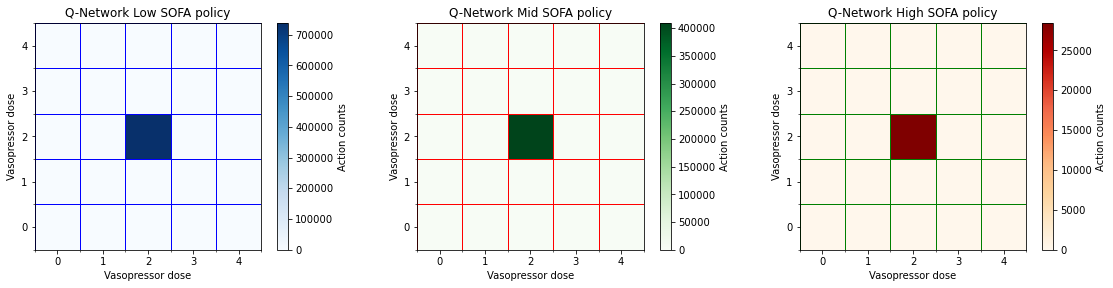

In [25]:
#Can ignore this for now
#Plot heatmap graphs on Q-network policy
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
ax1.imshow(np.flipud(hist_drl1), cmap="Blues",extent=[x_edges[0], x_edges[-1],  y_edges[0],y_edges[-1]])
ax2.imshow(np.flipud(hist_drl2), cmap="OrRd", extent=[x_edges[0], x_edges[-1],  y_edges[0],y_edges[-1]])
ax3.imshow(np.flipud(hist_drl3), cmap="Greens", extent=[x_edges[0], x_edges[-1],  y_edges[0],y_edges[-1]])


# ax1.grid(color='b', linestyle='-', linewidth=1)
# ax2.grid(color='r', linestyle='-', linewidth=1)
# ax3.grid(color='g', linestyle='-', linewidth=1)

# Major ticks
ax1.set_xticks(np.arange(0, 5, 1));
ax1.set_yticks(np.arange(0, 5, 1));
ax2.set_xticks(np.arange(0, 5, 1));
ax2.set_yticks(np.arange(0, 5, 1));
ax3.set_xticks(np.arange(0, 5, 1));
ax3.set_yticks(np.arange(0, 5, 1));


# Labels for major ticks
ax1.set_xticklabels(np.arange(0, 5, 1));
ax1.set_yticklabels(np.arange(0, 5, 1));
ax2.set_xticklabels(np.arange(0, 5, 1));
ax2.set_yticklabels(np.arange(0, 5, 1));
ax3.set_xticklabels(np.arange(0, 5, 1));
ax3.set_yticklabels(np.arange(0, 5, 1));


# Minor ticks
ax1.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax1.set_yticks(np.arange(-.5, 5, 1), minor=True);
ax2.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax2.set_yticks(np.arange(-.5, 5, 1), minor=True);
ax3.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax3.set_yticks(np.arange(-.5, 5, 1), minor=True);


# Gridlines based on minor ticks
ax1.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax2.grid(which='minor', color='r', linestyle='-', linewidth=1)
ax3.grid(which='minor', color='g', linestyle='-', linewidth=1)


im1 = ax1.pcolormesh(x_edges, y_edges, hist_drl1, cmap='Blues')
f.colorbar(im1, ax=ax1, label = "Action counts")

im2 = ax2.pcolormesh(x_edges, y_edges, hist_drl2, cmap='Greens')
f.colorbar(im2, ax=ax2, label = "Action counts")

im3 = ax3.pcolormesh(x_edges, y_edges, hist_drl3, cmap='OrRd')
f.colorbar(im3, ax=ax3, label = "Action counts")


ax1.set_ylabel('Vasopressor dose')
ax2.set_ylabel('Vasopressor dose')
ax3.set_ylabel('Vasopressor dose')
ax1.set_xlabel('Vasopressor dose')
ax2.set_xlabel('Vasopressor dose')
ax3.set_xlabel('Vasopressor dose')


ax1.set_title("Q-Network Low SOFA policy")
ax2.set_title("Q-Network Mid SOFA policy")
ax3.set_title("Q-Network High SOFA policy")
plt.tight_layout()

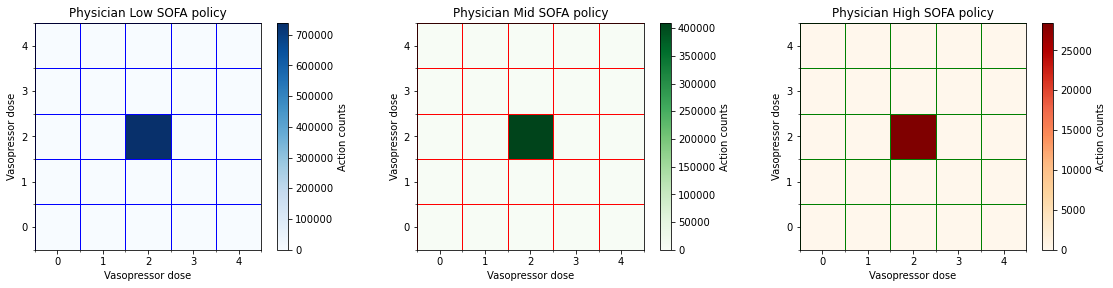

In [26]:
#Kai wen this should be run with your SARSA results
#Plot heatmap graphs on SARSA Physician policy
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
ax1.imshow(np.flipud(hist_ph1), cmap="Blues",extent=[x_edges[0], x_edges[-1],  y_edges[0],y_edges[-1]])
ax2.imshow(np.flipud(hist_ph2), cmap="OrRd", extent=[x_edges[0], x_edges[-1],  y_edges[0],y_edges[-1]])
ax3.imshow(np.flipud(hist_ph3), cmap="Greens", extent=[x_edges[0], x_edges[-1],  y_edges[0],y_edges[-1]])


# ax1.grid(color='b', linestyle='-', linewidth=1)
# ax2.grid(color='r', linestyle='-', linewidth=1)
# ax3.grid(color='g', linestyle='-', linewidth=1)

# Major ticks
ax1.set_xticks(np.arange(0, 5, 1));
ax1.set_yticks(np.arange(0, 5, 1));
ax2.set_xticks(np.arange(0, 5, 1));
ax2.set_yticks(np.arange(0, 5, 1));
ax3.set_xticks(np.arange(0, 5, 1));
ax3.set_yticks(np.arange(0, 5, 1));


# Labels for major ticks
ax1.set_xticklabels(np.arange(0, 5, 1));
ax1.set_yticklabels(np.arange(0, 5, 1));
ax2.set_xticklabels(np.arange(0, 5, 1));
ax2.set_yticklabels(np.arange(0, 5, 1));
ax3.set_xticklabels(np.arange(0, 5, 1));
ax3.set_yticklabels(np.arange(0, 5, 1));


# Minor ticks
ax1.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax1.set_yticks(np.arange(-.5, 5, 1), minor=True);
ax2.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax2.set_yticks(np.arange(-.5, 5, 1), minor=True);
ax3.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax3.set_yticks(np.arange(-.5, 5, 1), minor=True);


# Gridlines based on minor ticks
ax1.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax2.grid(which='minor', color='r', linestyle='-', linewidth=1)
ax3.grid(which='minor', color='g', linestyle='-', linewidth=1)


im1 = ax1.pcolormesh(x_edges, y_edges, hist_ph1, cmap='Blues')
f.colorbar(im1, ax=ax1, label = "Action counts")

im2 = ax2.pcolormesh(x_edges, y_edges, hist_ph2, cmap='Greens')
f.colorbar(im2, ax=ax2, label = "Action counts")

im3 = ax3.pcolormesh(x_edges, y_edges, hist_ph3, cmap='OrRd')
f.colorbar(im3, ax=ax3, label = "Action counts")


ax1.set_ylabel('Vasopressor dose')
ax2.set_ylabel('Vasopressor dose')
ax3.set_ylabel('Vasopressor dose')
ax1.set_xlabel('Vasopressor dose')
ax2.set_xlabel('Vasopressor dose')
ax3.set_xlabel('Vasopressor dose')


ax1.set_title("Physician Low SOFA policy")
ax2.set_title("Physician Mid SOFA policy")
ax3.set_title("Physician High SOFA policy")
plt.tight_layout()

In [27]:
def make_df_diff(op_actions, df_in):
    op_vaso_med = []
    for action in op_actions:
        vaso,vaso = inv_action_map[action]
        op_vaso_med.append(vaso_vals[vaso])
    vaso_diff = np.array(op_vaso_med) - np.array(df_in['vaso_amount'])
    df_diff = pd.DataFrame()
    df_diff['mort'] = np.array(df_in['died_in_hosp'])
    df_diff['vaso_diff'] = vaso_diff
    return df_diff

In [ ]:
#Don't run this box. Old code
from scipy.stats import sem
def make_iv_plot_data(df_diff):
    bin_medians_iv = []
    mort_iv = []
    mort_std_iv= []
    i = -800
    while i <= 900:
        count =df_diff.loc[(df_diff['iv_diff']>i-50) & (df_diff['iv_diff']<i+50)]
        try:
            res = sum(count['mort'])/float(len(count))
            if len(count) >=2:
                bin_medians_iv.append(i)
                mort_iv.append(res)
                mort_std_iv.append(sem(count['mort']))
        except ZeroDivisionError:
            pass
        i += 100
    return bin_medians_iv, mort_iv, mort_std_iv

In [28]:
from scipy.stats import sem
def make_vaso_plot_data(df_diff):
    bin_medians_vaso = []
    mort_vaso= []
    mort_std_vaso= []
    i = -0.6
    while i <= 0.6:
        count =df_diff.loc[(df_diff['vaso_diff']>i-0.05) & (df_diff['vaso_diff']<i+0.05)]
        try:
            res = sum(count['mort'])/float(len(count))
            if len(count) >=2:
                bin_medians_vaso.append(i)
                mort_vaso.append(res)
                mort_std_vaso.append(sem(count['mort']))
        except ZeroDivisionError:
            pass
        i += 0.1
    return bin_medians_vaso, mort_vaso, mort_std_vaso

In [29]:
df_diff_low = make_df_diff(deeprl2_actions_low, df_test_orig_low)
df_diff_mid = make_df_diff(deeprl2_actions_mid, df_test_orig_mid)
df_diff_high = make_df_diff(deeprl2_actions_high, df_test_orig_high)

In [30]:
bin_med_vaso_deep_low, mort_vaso_deep_low, mort_std_vaso_deep_low = make_vaso_plot_data(df_diff_low)

bin_med_vaso_deep_mid, mort_vaso_deep_mid, mort_std_vaso_deep_mid = make_vaso_plot_data(df_diff_mid)

bin_med_vaso_deep_high, mort_vaso_deep_high, mort_std_vaso_deep_high = make_vaso_plot_data(df_diff_high)

In [30]:
#Don't run this box. Old code
def diff_plot(med_vaso, mort_vaso, std_vaso, col, title):
    f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row', figsize = (10,4))
    step = 2
    if col == 'r':
        fillcol = 'lightsalmon'
    elif col == 'g':
        fillcol = 'palegreen'
        step = 1
    elif col == 'b':
        fillcol = 'lightblue'
    ax1.plot(med_vaso, sliding_mean(mort_vaso), color=col)
    ax1.fill_between(med_vaso, sliding_mean(mort_vaso) - 1*std_vaso,  
                     sliding_mean(mort_vaso) + 1*std_vaso, color=fillcol)
    t = title + ": Vasopressors"
    ax1.set_title(t)
    x_r = [i/10.0 for i in range(-6,8,2)]

    y_r = [i/20.0 for i in range(0,20,step)]
    ax1.set_xticks(x_r)
    ax1.set_yticks(y_r)
    ax1.grid()

    ax2.plot(bin_med_vaso_auto, sliding_mean(mort_vaso_auto), color='g')
    ax2.fill_between(bin_med_vaso_auto, sliding_mean(mort_vaso_auto) - 1*mort_std_vaso_auto,  
                     sliding_mean(mort_vaso_auto) + 1*mort_std_vaso_auto, color='palegreen')
    y_auto = [i/20.0 for i in range(0,21,1)]
    ax2.set_yticks(y_auto)
    ax2.set_title('Q-Network (Shaped Rewards) - Vasopressors')
    ax2.grid()

    f.text(0.5, -0.03, 'Difference between optimal and physician vasopressor dose', ha='center', fontsize=10)
    f.text(0.05, 0.5, 'Observed Mortality', va='center', rotation='vertical', fontsize = 10)

In [31]:
def diff_plot(med_vaso, mort_vaso, std_vaso, col, title):
    f, ax1 = plt.subplots(1, 1, sharex='col', sharey='row', figsize = (8,4))
    step = 2
    if col == 'r':
        fillcol = 'lightsalmon'
    elif col == 'g':
        fillcol = 'palegreen'
        step = 1
    elif col == 'b':
        fillcol = 'lightblue'
    ax1.plot(med_vaso, sliding_mean(mort_vaso), color=col)
    ax1.fill_between(med_vaso, sliding_mean(mort_vaso) - 1*std_vaso,  
                     sliding_mean(mort_vaso) + 1*std_vaso, color=fillcol)
    t = title + ": Vasopressors"
    ax1.set_title(t)
    x_r = [i/10.0 for i in range(-6,8,2)]

    y_r = [i/20.0 for i in range(0,20,step)]
    ax1.set_xticks(x_r)
    ax1.set_yticks(y_r)
    ax1.grid()

    f.text(0.5, -0.03, 'Difference between optimal and physician vasopressor dose', ha='center', fontsize=10)
    f.text(0.05, 0.5, 'Observed Mortality', va='center', rotation='vertical', fontsize = 10)


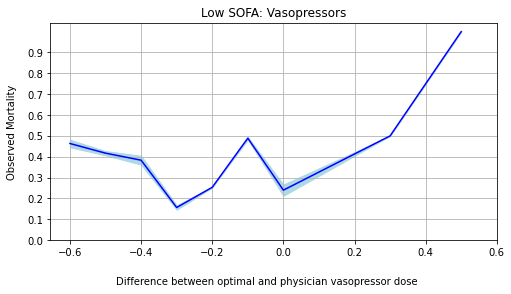

In [32]:
diff_plot(bin_med_vaso_deep_low, mort_vaso_deep_low, mort_std_vaso_deep_low, 'b', 'Low SOFA')

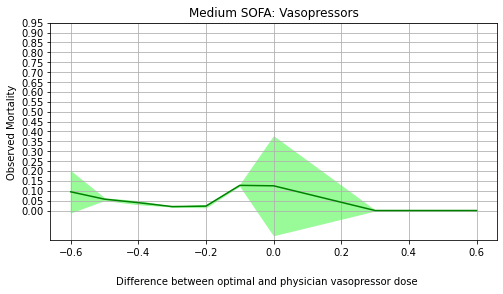

In [33]:
diff_plot(bin_med_vaso_deep_mid, mort_vaso_deep_mid, mort_std_vaso_deep_mid, 'g', 'Medium SOFA')

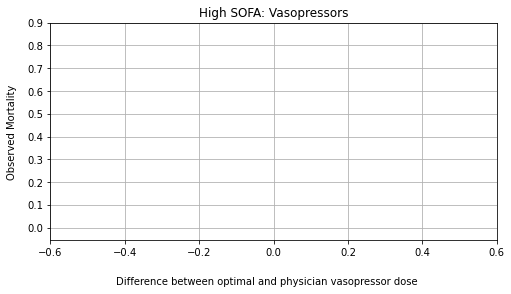

In [35]:
diff_plot(bin_med_vaso_deep_high, mort_vaso_deep_high, mort_std_vaso_deep_high, 'r', 'High SOFA')